In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import ndimage
import pandas as pd
import os
from tqdm import tqdm

import sys         
sys.path.append('/home/aulegoup/Optical_fibers/Absorption_spectra_experiments') 
from MSsmoothing import smoothMS


In [2]:
imfile = "post30kV80pA_trench2_Cdep_z2.tif"
scalevalue = 200
scaleunit = "nm"
tilt_deg = 52 #°
globalmax = True

# imfile = "post30kV80pA_trench2_Cdep_zo3.tif"
# scalevalue = 500
# scaleunit = "nm"
# tilt_deg = 52 #°
# globalmax = True

6144 4376


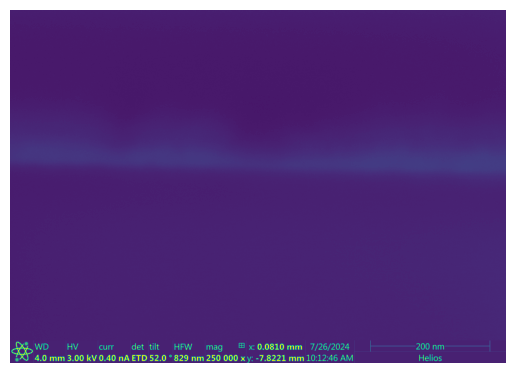

In [3]:
im = Image.open(imfile)
width, height = im.size 
print(width,height)
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(im)
plt.show()

# Finding the scale (nm/pixel)

(1844, 438)


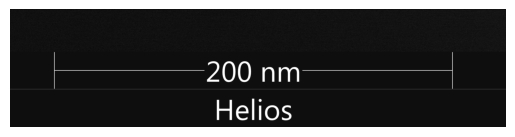

In [4]:
#Get the scale to pixel ratio
left = (width*2.1)//3
right = width
top = (height*9)//10
bottom = height

im_scale = im.crop((left, top, right, bottom))
print(im_scale.size)
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(im_scale, cmap='gray')
plt.show()

164 1646


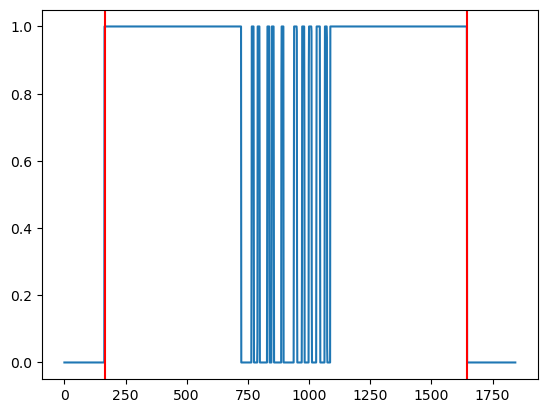

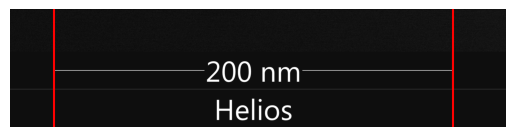

In [5]:
# Convert the cropped image to grayscale
im_scale.getpixel(((1844*2)//3,219))

vertical = [ im_scale.getpixel((((right-left)*2)//3,i)) for i in range(int(bottom-top))]
vert_middle = np.argmax(vertical)

scalebar = np.array([ im_scale.getpixel((i,vert_middle)) for i in range(int(right-left))])
scalebar = (scalebar-np.min(scalebar))/(np.max(scalebar)-np.min(scalebar))

first_pix = next(i for i,val in enumerate(scalebar) if val>0.5)
last_pix = next(i for i,val in enumerate(scalebar) if np.all(scalebar[i:]<0.5))
print(first_pix,last_pix)

plt.plot(scalebar)
plt.axvline(x=first_pix,color='r')
plt.axvline(x=last_pix,color='r')
# plt.xlim()
plt.show()

fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(im_scale, cmap='gray')
plt.axvline(x=first_pix,color='r')
plt.axvline(x=last_pix,color='r')
plt.show()

In [6]:
pixelsize = scalevalue/(last_pix-first_pix)

print(f"The scale in this picture corresponds to {pixelsize:.4f} {scaleunit}/pixel.")

pixelsize_withtilt = pixelsize/np.sin(tilt_deg*np.pi/180)

print(f"The thickness on the cross section corresponds to {pixelsize_withtilt:.4f} {scaleunit}/pixel with the tilt ({tilt_deg}°) correction.")

The scale in this picture corresponds to 0.1350 nm/pixel.
The thickness on the cross section corresponds to 0.1713 nm/pixel with the tilt (52°) correction.


# Finding the mean thickness

(6144, 3938)


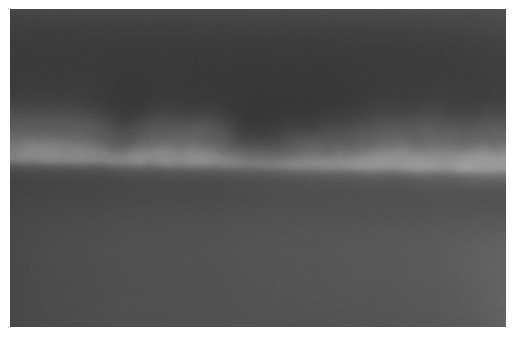

In [7]:
#Get the scale to pixel ratio
left = 0
right = width
top = 0
bottom = (height*9)//10

im_meas = im.crop((left, top, right, bottom))
print(im_meas.size)
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(im_meas, cmap='gray')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 6144/6144 [00:40<00:00, 152.95it/s]


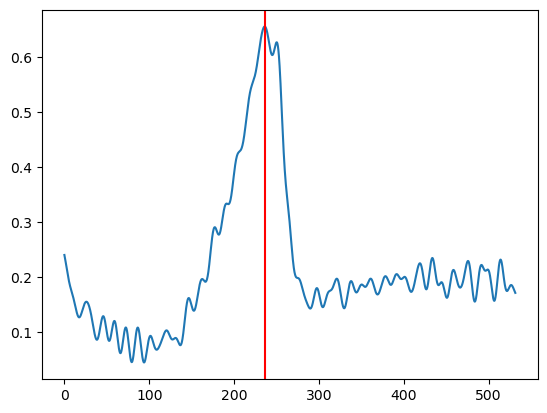

In [8]:
test_x=np.linspace(0,width-1,num=width,dtype=int)
# print(test_x)
relintensity_thresh = 0.55

VERT = [[ im_meas.getpixel((x,i)) for i in range(int(bottom-top))] for x in test_x]

# Apply the convolution to perform the moving average filtering
VERT = [smoothMS(line, 2,400) for line in tqdm(VERT)]
if globalmax:
    maxint,minint=np.max(VERT),np.min(VERT)
    VERT = [(line-minint)/(maxint-minint) for line in (VERT)]
else:
    VERT = [(line-min(line))/(max(line)-min(line)) for line in (VERT)]

VERT=np.array(VERT)
maxiVERT = np.argmax(VERT,axis=1)

test_x,VERT,maxiVERT = test_x[maxiVERT>100],VERT[maxiVERT>100],maxiVERT[maxiVERT>100]

bottomAu = [ next(j for j in range(maxiVERT[i],len(line)) if line[j]<relintensity_thresh) for i,line in (enumerate(VERT))]
topAu = [ next(j for j in range(maxiVERT[i],-1,-1) if line[j]<relintensity_thresh) for i,line in (enumerate(VERT))]

for i in range(1):#len(VERT)):
    plt.plot(np.arange(bottom)*pixelsize,VERT[i],label=test_x[i])
    plt.axvline(x=maxiVERT[i]*pixelsize,color='r')
    # plt.axvline(x=bottomAu[i]*pixelsize,color='b')
    # plt.axvline(x=topAu[i]*pixelsize,color='g')
plt.show()

Relative intensity threshold : 0.55
The average gold coating thickness is 45.60444039248013 nm with the tilt (52°) correction.


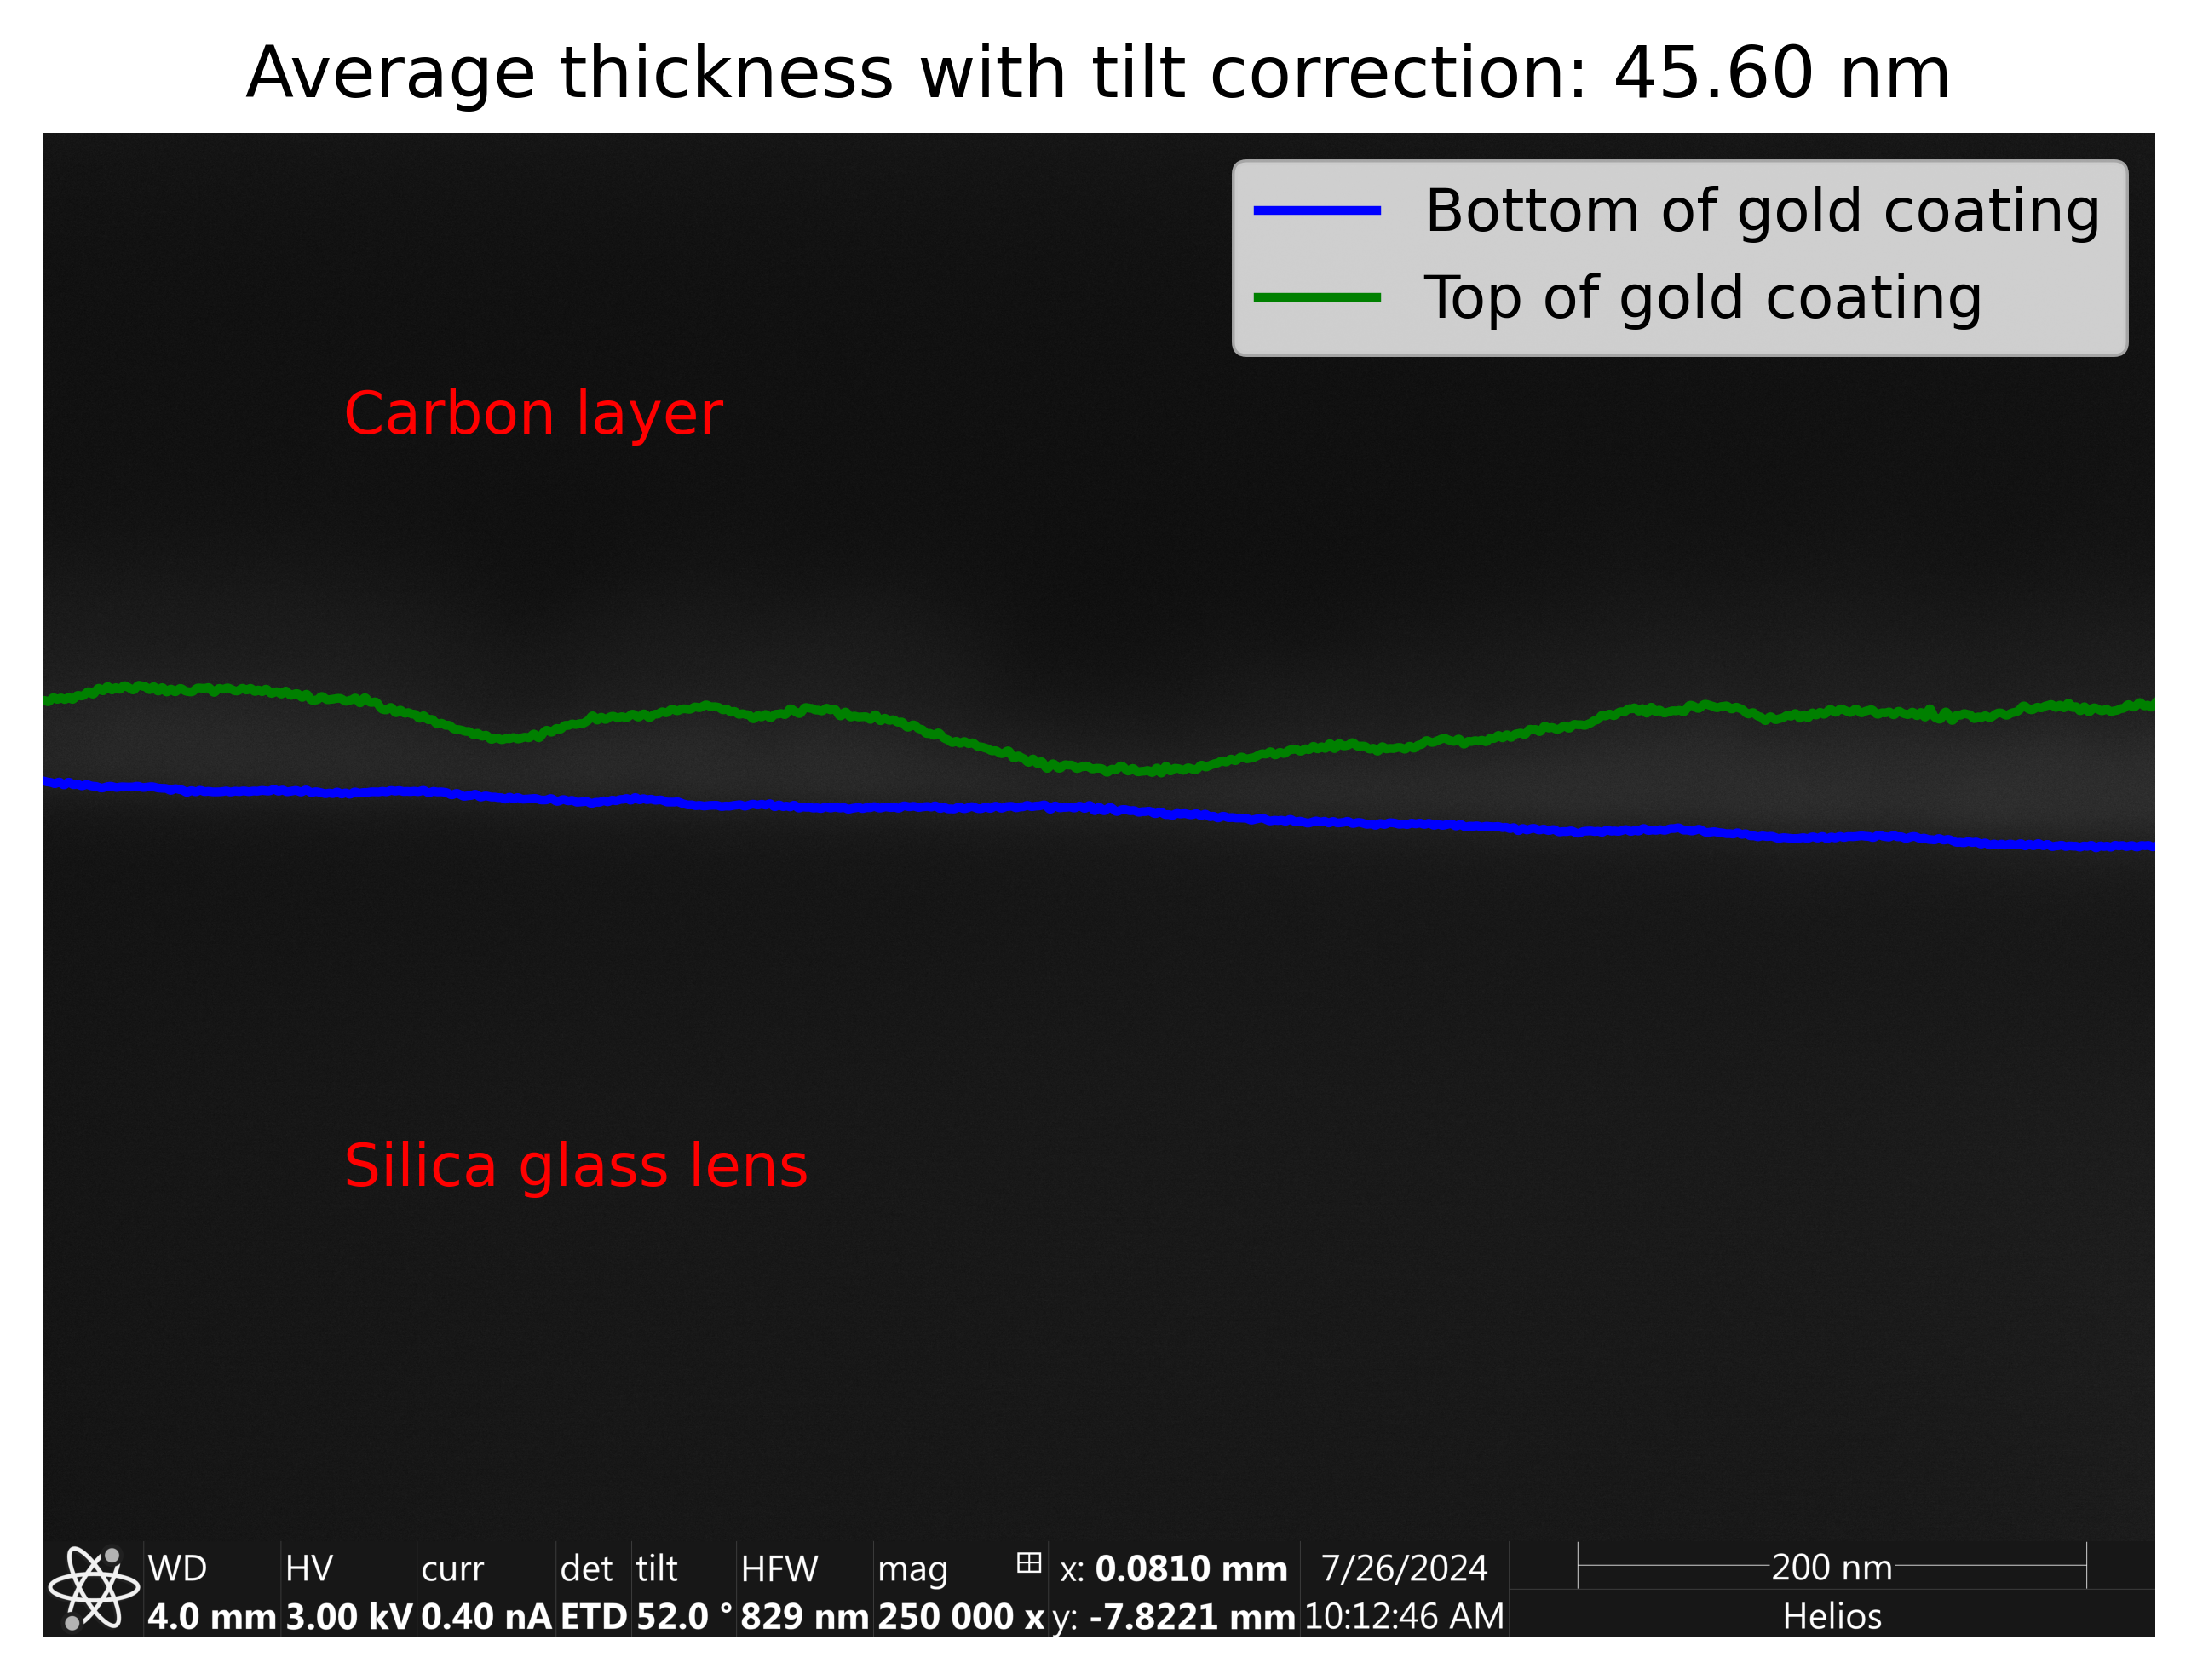

In [9]:
bottomAu_sm=smoothMS(bottomAu, 2,100)
topAu_sm=smoothMS(topAu, 2,100)

avgthickness = np.mean(bottomAu_sm-topAu_sm)*pixelsize_withtilt
print(f"Relative intensity threshold : {relintensity_thresh}")
print(f"The average gold coating thickness is {avgthickness} {scaleunit} with the tilt ({tilt_deg}°) correction.")

fig, ax = plt.subplots()
fig.set_dpi(500)
ax.axis("off")
plt.imshow(im, cmap='gray') #im_meas
# plt.plot(test_x,maxiVERT,color='r')
plt.plot(test_x,bottomAu_sm,color='b',label="Bottom of gold coating")
plt.plot(test_x,topAu_sm,color='g',label="Top of gold coating")
plt.title(f"Average thickness with tilt correction: {avgthickness:.2f} {scaleunit}")
plt.text(height/5,height/5,"Carbon layer",color="r")
plt.text(height/5,height*3.5/5,"Silica glass lens",color="r")
plt.legend()

SAVE=True
if SAVE:
    plotname = imfile.split(".tif")[0]+" - thickness measurement.pdf"
    plt.savefig(plotname,bbox_inches="tight")
else:
    plt.show()